In [12]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.cross_decomposition import CCA
import pandas as pd
import scipy.io

In [ ]:
fs = 250 
start_time = 0.64  
bloco = 2           
eletrodos_alvo = ['PZ', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'O1', 'Oz', 'O2'] 

In [14]:
channels_df = pd.read_csv('64-channels.loc', delim_whitespace=True, header=None, 
                          names=["idx", "x", "y", "label"])

In [15]:
idx_eletrodos = []
for eletrodo in eletrodos_alvo:
    idx = int(channels_df[channels_df['label'] == eletrodo]['idx'].iloc[0])
    idx_eletrodos.append(idx)

In [16]:
mat = scipy.io.loadmat('S3.mat')
data = mat['data']

In [17]:
freq_phase = scipy.io.loadmat('Freq_Phase.mat')
freqs_estimulo = freq_phase['freqs'] 

In [ ]:
duracoes = np.arange(0.5, 5.25, 0.25)  #Janelas de amostragem (step de 0.25)
harmonicas_configs = [1, 2, 3, 4, 5, 6]  #Número de harmônicas
num_trials = 240  #Total de trials
num_classes = 40 

In [ ]:
def gerar_sinais_referencia(freq, duracao, num_harmonicas, fs, start_sample, end_sample):
    #t = np.linspace(0, duracao, int(duracao * fs), endpoint=False)
    t = np.linspace(0, (end_sample - start_sample)/fs, end_sample - start_sample, endpoint=False)
    
    sinais = []
    for h in range(1, num_harmonicas + 1):
        sinais.append(np.sin(2 * np.pi * h * freq * t))
        sinais.append(np.cos(2 * np.pi * h * freq * t))
    
    return np.vstack(sinais).T

In [ ]:
def aplicar_cca_classificacao(eeg_data, freqs_estimulo, duracao, num_harmonicas, fs, start_sample, end_sample):
    num_amostras = int(duracao * fs)
    rho_values = np.zeros(num_classes)
    
    for m in range(num_classes):
        f = freqs_estimulo[0, m]
        
        Y_ref = gerar_sinais_referencia(f, duracao, num_harmonicas, fs, start_sample, end_sample)
        
        cca = CCA(n_components=1)
        try:
            X_cca, Y_cca = cca.fit_transform(eeg_data[:num_amostras].reshape(-1, 1), Y_ref)
            rho = np.corrcoef(X_cca.T, Y_cca.T)[0, 1]
            rho_values[m] = abs(rho) 
        except:
            rho_values[m] = 0
    
    return rho_values

In [ ]:
def calcular_acuracia_itr(duracoes, harmonicas_configs):
    resultados = {}
    
    for num_harmonicas in harmonicas_configs:
        acuracias = []
        itrs = []
        
        print(f"{num_harmonicas} harmônica(s)")
        
        for duracao in duracoes:
            print(f"  Duração: {duracao:.2f}s")
            
            start_sample = int(start_time * fs)
            end_sample = start_sample + int(duracao * fs)
            
            acertos = 0
            
            #Testa todos os alvos e blocos disponíveis (6*240)
            for bloco_teste in range(min(6, data.shape[3])):
                for alvo in range(num_classes):
                    try:
                        #Extrai e filtra sinais
                        signals = np.zeros((len(idx_eletrodos), end_sample - start_sample))
                        for i, idx in enumerate(idx_eletrodos):
                            signal = data[idx, start_sample:end_sample, alvo, bloco_teste]
                            b, a = butter(4, 3 / (fs / 2), btype='highpass')
                            #b, a = butter(4, [7 / (fs / 2), 70 / (fs / 2)], btype='bandpass')
                            signals[i] = filtfilt(b, a, signal)
                        
                        #Média dos canais
                        eeg_window = np.mean(signals, axis=0)
                        
                        rho_values = aplicar_cca_classificacao(eeg_window, freqs_estimulo, 
                                                             duracao, num_harmonicas, fs, start_sample, end_sample)
                        
                        predicao = np.argmax(rho_values)
                        
                        if predicao == alvo:
                            acertos += 1
                        
                    except:
                        continue
            
            acuracia = acertos / num_trials
            
       
            itr = (np.log2(num_classes) + acuracia * np.log2(acuracia) + 
                       (1-acuracia) * np.log2((1-acuracia)/(num_classes-1))) * (60/(0.55+duracao))
            
            acuracias.append(acuracia)
            itrs.append(max(itr, 0)) 
        
        resultados[num_harmonicas] = {
            'acuracias': np.array(acuracias),
            'itrs': np.array(itrs)
        }
        
    
    return resultados

1 harmônica(s)
  Duração: 0.50s
  Duração: 0.75s
  Duração: 1.00s
  Duração: 1.25s
  Duração: 1.50s
  Duração: 1.75s
  Duração: 2.00s
  Duração: 2.25s
  Duração: 2.50s
  Duração: 2.75s
  Duração: 3.00s
  Duração: 3.25s
  Duração: 3.50s
  Duração: 3.75s
  Duração: 4.00s
  Duração: 4.25s
  Duração: 4.50s
  Duração: 4.75s
  Duração: 5.00s
  Acurácia máxima: 0.742
  ITR máximo: 37.22 bits/min
2 harmônica(s)
  Duração: 0.50s
  Duração: 0.75s
  Duração: 1.00s
  Duração: 1.25s
  Duração: 1.50s
  Duração: 1.75s
  Duração: 2.00s
  Duração: 2.25s
  Duração: 2.50s
  Duração: 2.75s
  Duração: 3.00s
  Duração: 3.25s
  Duração: 3.50s
  Duração: 3.75s
  Duração: 4.00s
  Duração: 4.25s
  Duração: 4.50s
  Duração: 4.75s
  Duração: 5.00s
  Acurácia máxima: 0.821
  ITR máximo: 47.42 bits/min
3 harmônica(s)
  Duração: 0.50s
  Duração: 0.75s
  Duração: 1.00s
  Duração: 1.25s
  Duração: 1.50s
  Duração: 1.75s
  Duração: 2.00s
  Duração: 2.25s
  Duração: 2.50s
  Duração: 2.75s
  Duração: 3.00s
  Duração: 3.2

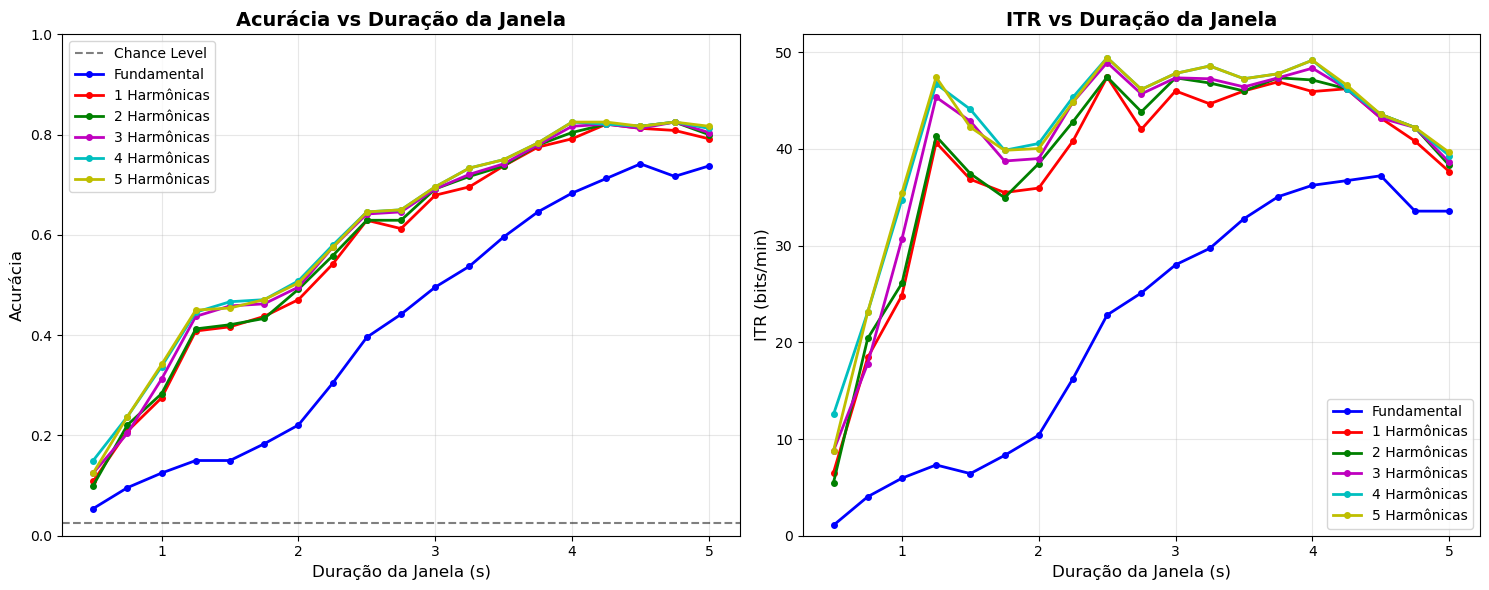

In [ ]:
resultados = calcular_acuracia_itr(duracoes, harmonicas_configs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cores = ['b-', 'r-', 'g-', 'm-', 'c-', 'y-']
labels = ['Fundamental', '1 Harmônicas', '2 Harmônicas', '3 Harmônicas', '4 Harmônicas', '5 Harmônicas']

ax1.set_title('Acurácia vs Duração da Janela', fontsize=14, fontweight='bold')
ax1.set_xlabel('Duração da Janela (s)', fontsize=12)
ax1.set_ylabel('Acurácia', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1/num_classes, color='k', linestyle='--', alpha=0.5, label='Chance Level')

for i, num_harmonicas in enumerate(harmonicas_configs):
    ax1.plot(duracoes, resultados[num_harmonicas]['acuracias'], 
             cores[i], linewidth=2, marker='o', markersize=4, label=labels[i])

ax1.legend()
ax1.set_ylim(0, 1)

ax2.set_title('ITR vs Duração da Janela', fontsize=14, fontweight='bold')
ax2.set_xlabel('Duração da Janela (s)', fontsize=12)
ax2.set_ylabel('ITR (bits/min)', fontsize=12)
ax2.grid(True, alpha=0.3)

for i, num_harmonicas in enumerate(harmonicas_configs):
    ax2.plot(duracoes, resultados[num_harmonicas]['itrs'], 
             cores[i], linewidth=2, marker='o', markersize=4, label=labels[i])

ax2.legend()
ax2.set_ylim(0, None)

plt.tight_layout()
plt.show()